<a href="https://colab.research.google.com/github/utkarshsharma1/ECG_Signals/blob/master/Utkarsh_ecg_1D_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

!pip install pyyaml h5py  # Required to save models in HDF5 format

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Load Data

In [0]:
# Training dataset.
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data_ecg/train_aug_v2.csv", header=None)
x_train = df.values[:, :-1]
y_train = df.values[:, -1].astype(int)

# Validation dataset.
#df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data_ecg/validate.csv", header=None)
#x_validate = df.values[:, :-1]
#y_validate = df.values[:, -1].astype(int)

# Test dataset.
df = pd.read_csv("/content/drive/My Drive/Colab Notebooks/data_ecg/test_aug_v2.csv", header=None)
x_test = df.values[:, :-1]
y_test = df.values[:, -1].astype(int)

In [0]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [0]:
print(np.unique(y_train, return_counts = True))
print(np.unique(y_validate, return_counts = True))
print(np.unique(y_test, return_counts = True))
print(x_test.shape, y_test.shape)
print(x_validate.shape, y_validate.shape)
print(x_train.shape, y_train.shape)

#print(np.unique(y_train, return_counts = True) + np.unique(y_validate, return_counts = True) + np.unique(y_test, return_counts = True))

(array([0, 1, 2, 3, 4]), array([78468, 19334, 30491, 12782, 31020]))
(array([0, 1, 2, 3, 4]), array([26248,  6439, 10068,  4363, 10248]))
(array([0, 1, 2, 3, 4]), array([8000, 8000, 8000, 8000, 8000]))
(40000, 187) (40000,)
(57366, 187) (57366,)
(172095, 187) (172095,)


In [0]:
a = np.unique(y_test, return_counts = True)
print(a[1])

[8000 8000 8000 8000 8000]


In [0]:
C0 = np.argwhere(y_train == 0).flatten()
C1 = np.argwhere(y_train == 1).flatten()
C2 = np.argwhere(y_train == 2).flatten()
C3 = np.argwhere(y_train == 3).flatten()
C4 = np.argwhere(y_train == 4).flatten()

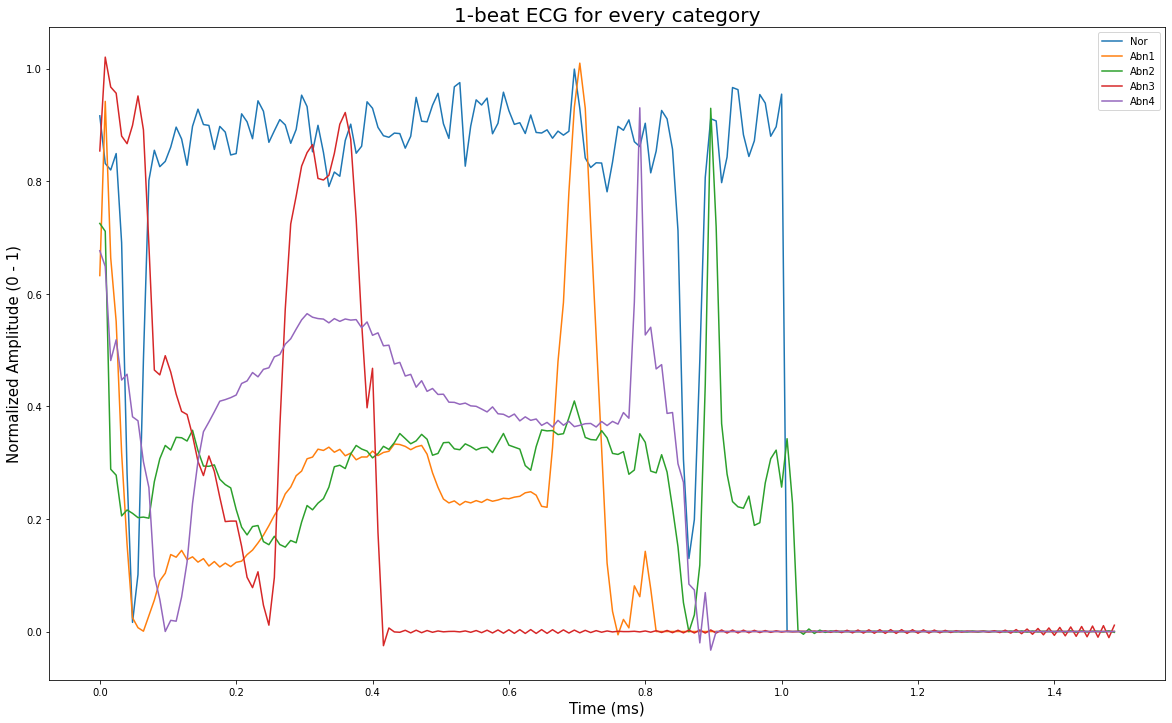

In [0]:
x = np.arange(0, 187)*8/1000.0

plt.figure(figsize=(20,12))
plt.plot(x, x_train[C0, :][0], label="Nor") # Display first normal beat.
plt.plot(x, x_train[C1, :][0], label="Abn1") # Display first abnormal beat.
plt.plot(x, x_train[C2, :][0], label="Abn2") # Display first abnormal beat.
plt.plot(x, x_train[C3, :][0], label="Abn3") # Display first abnormal beat.
plt.plot(x, x_train[C4, :][0], label="Abn4") # Display first abnormal beat.

plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Normalized Amplitude (0 - 1)", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

#Our CNN Model

In [0]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv1D, Flatten, Dropout, MaxPooling1D, Input, Softmax, Add, Activation

from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [0]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_validate = np.reshape(x_validate, (x_validate.shape[0], x_validate.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
print(x_train.shape, x_validate.shape, x_test.shape)

(172095, 187, 1) (57366, 187, 1) (40000, 187, 1)


In [0]:
y_train = to_categorical(y_train)
y_validate = to_categorical(y_validate)
y_test = to_categorical(y_test)

print(y_train.shape, y_validate.shape, y_test.shape)

(172095, 5) (57366, 5) (40000, 5)


In [0]:
n_obs, feature, depth = x_train.shape
batch_size = 500

In [0]:
K.clear_session()

inp = Input(shape=(feature, depth))
C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
A11 = Activation("relu")(C11)
C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
S11 = Add()([C12, C])
A12 = Activation("relu")(S11)
M11 = MaxPooling1D(pool_size=5, strides=2)(A12)


C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
A21 = Activation("relu")(C21)
C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
S21 = Add()([C22, M11])
A22 = Activation("relu")(S21)
M21 = MaxPooling1D(pool_size=5, strides=2)(A22)


C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
A31 = Activation("relu")(C31)
C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
S31 = Add()([C32, M21])
A32 = Activation("relu")(S31)
M31 = MaxPooling1D(pool_size=5, strides=2)(A32)


C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
A41 = Activation("relu")(C41)
C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
S41 = Add()([C42, M31])
A42 = Activation("relu")(S41)
M41 = MaxPooling1D(pool_size=5, strides=2)(A42)


C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
A51 = Activation("relu")(C51)
C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
S51 = Add()([C52, M41])
A52 = Activation("relu")(S51)
M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

F1 = Flatten()(M51)

D1 = Dense(32)(F1)
A6 = Activation("relu")(D1)
D2 = Dense(32)(A6)
D3 = Dense(5)(D2)
A7 = Softmax()(D3)

model = Model(inputs=inp, outputs=A7)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      5152        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 183, 32)      0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
def exp_decay(epoch):
    initial_lrate = 0.001
    k = 0.75
    t = n_obs//(10000 * batch_size)  # every epoch we do n_obs/batch_size iteration
    lrate = initial_lrate * math.exp(-k*t)
    return lrate

lrate = LearningRateScheduler(exp_decay)

In [0]:
adam = Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999)

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = adam,
    metrics = ['accuracy']
)

In [0]:
history = model.fit(x_train, y_train, 
                    epochs = 10, 
                    batch_size = batch_size, 
                    verbose = 1,
                    validation_data = (x_validate, y_validate), 
                    callbacks=[lrate])

Epoch 1/10
345/345 [==============================] - 167s 484ms/step - loss: 0.2576 - accuracy: 0.9065 - val_loss: 0.1755 - val_accuracy: 0.9414 - lr: 0.0010
Epoch 2/10
345/345 [==============================] - 166s 482ms/step - loss: 0.0578 - accuracy: 0.9809 - val_loss: 0.0361 - val_accuracy: 0.9882 - lr: 0.0010
Epoch 3/10
345/345 [==============================] - 167s 484ms/step - loss: 0.0302 - accuracy: 0.9904 - val_loss: 0.0276 - val_accuracy: 0.9912 - lr: 0.0010
Epoch 4/10
345/345 [==============================] - 167s 484ms/step - loss: 0.0221 - accuracy: 0.9929 - val_loss: 0.0261 - val_accuracy: 0.9921 - lr: 0.0010
Epoch 5/10
345/345 [==============================] - 166s 482ms/step - loss: 0.0178 - accuracy: 0.9944 - val_loss: 0.0165 - val_accuracy: 0.9951 - lr: 0.0010
Epoch 6/10
345/345 [==============================] - 167s 485ms/step - loss: 0.0139 - accuracy: 0.9954 - val_loss: 0.0161 - val_accuracy: 0.9948 - lr: 0.0010
Epoch 7/10
345/345 [==========================

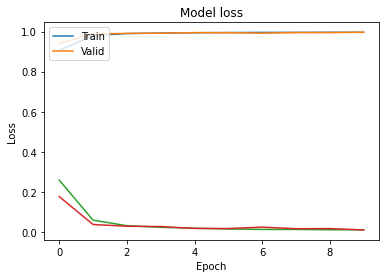

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()
#plt.savefig('/content/drive/My Drive/Colab Notebooks/model_acc.jpg')

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Valid'], loc='upper left')
plt.show()
#plt.savefig('/content/drive/My Drive/Colab Notebooks/acc_loss.jpg')

In [0]:
y_train_preds = model.predict(x_train, verbose = 1)
y_validate_preds = model.predict(x_validate, verbose = 1)
y_test_preds = model.predict(x_test)

1793/1793 [==============================] - 18s 10ms/step


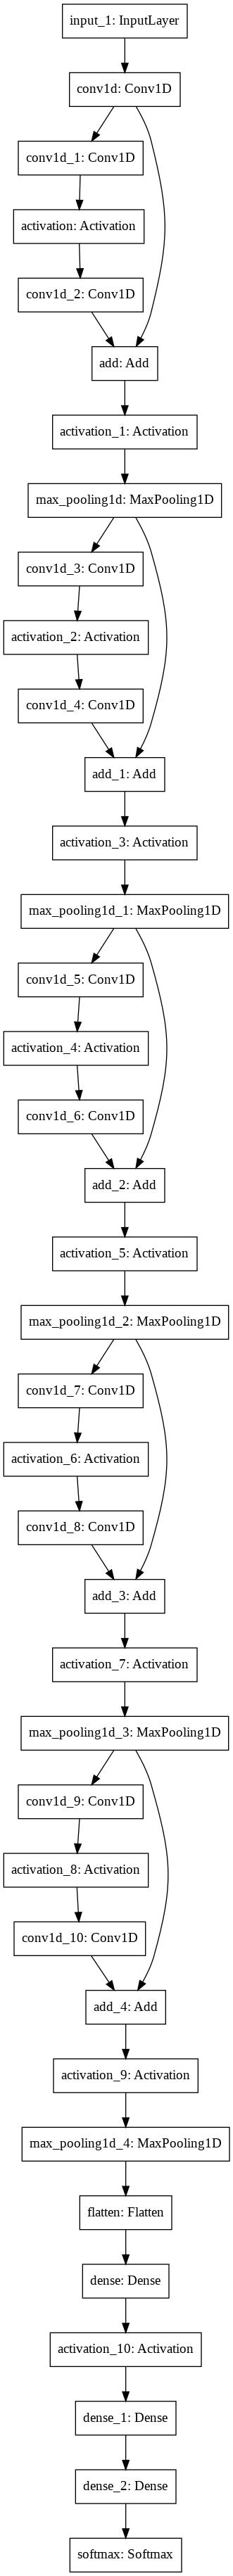

In [0]:
plot_model(
    model, to_file='/content/drive/My Drive/Colab Notebooks/model1.jpg', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=True, dpi=96
)

In [0]:
# Python script for confusion matrix creation. 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

In [0]:
y_train_preds = [np.argmax(i) for i in y_train_preds ]
y_train = [np.argmax(i) for i in y_train ]

y_validate_preds = [np.argmax(i) for i in y_validate_preds ]
y_validate = [np.argmax(i) for i in y_validate]

y_test_preds = [np.argmax(i) for i in y_test_preds ]
y_test = [np.argmax(i) for i in y_test ]

In [0]:
results = confusion_matrix(y_train, y_train_preds) 
  
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_train, y_train_preds))
print ('Report : ')
print (classification_report(y_train, y_train_preds)) 


cm = results.astype('float') / results.sum(axis=1)[:, np.newaxis]
nrows, ncols = cm.shape
annot = np.empty_like(cm).astype(str)

fig, ax = plt.subplots(figsize=(10, 10))
for i in range(nrows):
    for j in range(ncols):
        p = cm[i, j]
        if i == j:
            annot[i, j] = '%.1f' % (p)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.001f' % (p)
sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

Confusion Matrix :
[[22396     8     6    85     2]
 [    7  1339     0     0     0]
 [    8     0  1886     2     0]
 [   22     6     2   921     0]
 [    5     0     0     6  1919]]
Accuracy Score : 0.9944444444444445
Report : 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22497
           1       0.99      0.99      0.99      1346
           2       1.00      0.99      1.00      1896
           3       0.91      0.97      0.94       951
           4       1.00      0.99      1.00      1930

    accuracy                           0.99     28620
   macro avg       0.98      0.99      0.98     28620
weighted avg       0.99      0.99      0.99     28620



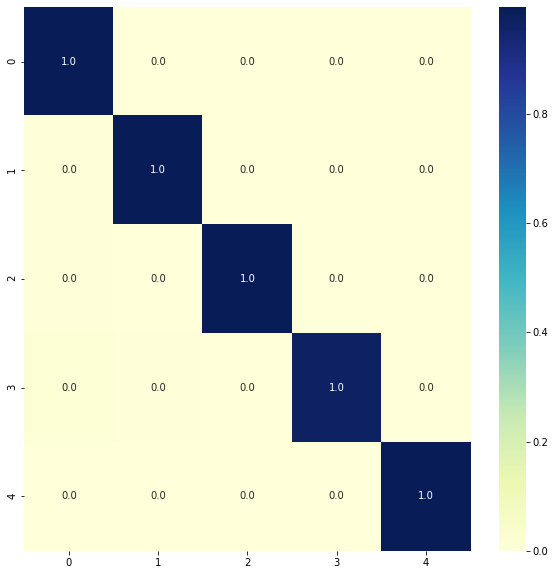

In [0]:
results = confusion_matrix(y_validate, y_validate_preds) 
  
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_validate, y_validate_preds))
print ('Report : ')
print (classification_report(y_validate, y_validate_preds))

cm = results.astype('float') / results.sum(axis=1)[:, np.newaxis]
nrows, ncols = cm.shape
annot = np.empty_like(cm).astype(str)

fig, ax = plt.subplots(figsize=(10, 10))
for i in range(nrows):
    for j in range(ncols):
        p = cm[i, j]
        if i == j:
            annot[i, j] = '%.1f' % (p)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.001f' % (p)
sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

Confusion Matrix :
[[7990    2    1    6    1]
 [  15 7981    0    4    0]
 [   4    0 7990    6    0]
 [ 170   16    5 7805    4]
 [   2    0    2    2 7994]]
Accuracy Score : 0.994
Report : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8000
           1       1.00      1.00      1.00      8000
           2       1.00      1.00      1.00      8000
           3       1.00      0.98      0.99      8000
           4       1.00      1.00      1.00      8000

    accuracy                           0.99     40000
   macro avg       0.99      0.99      0.99     40000
weighted avg       0.99      0.99      0.99     40000



NameError: ignored

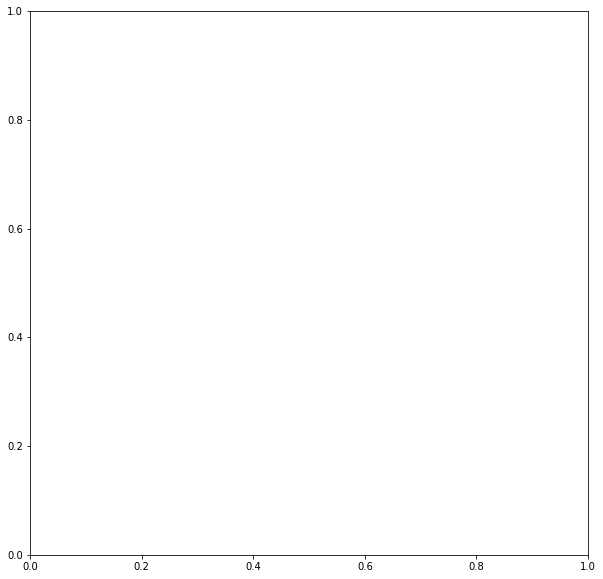

In [0]:
results = confusion_matrix(y_test, y_test_preds) 
  
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_test_preds))
print ('Report : ')
print (classification_report(y_test, y_test_preds))

cm = results.astype('float') / results.sum(axis=1)[:, np.newaxis]
nrows, ncols = cm.shape
annot = np.empty_like(cm).astype(str)

fig, ax = plt.subplots(figsize=(10, 10))
for i in range(nrows):
    for j in range(ncols):
        p = cm[i, j]
        if i == j:
            annot[i, j] = '%.01f%%' % (p)
        else:
            annot[i, j] = '%.01f%%' % (p)
sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

In [0]:
def plot_cm(y_true, y_pred, type, figsize=(10,10)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = '0'
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns_plot = sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
    fig = sns_plot.get_figure()
    fig.savefig("/content/drive/My Drive/Colab Notebooks/" + type + "output.png")

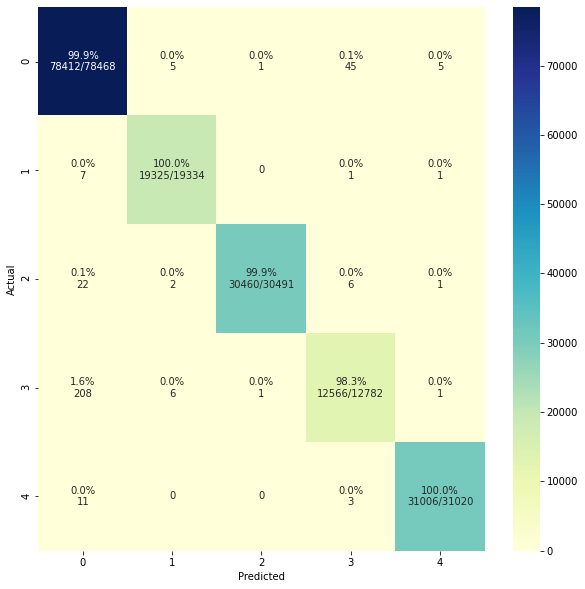

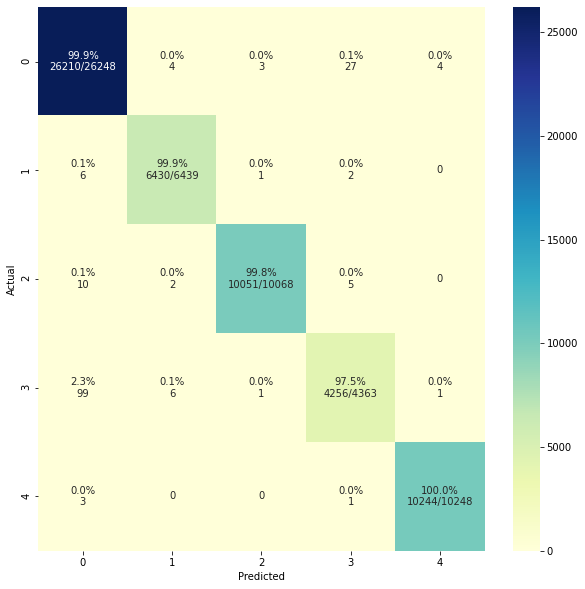

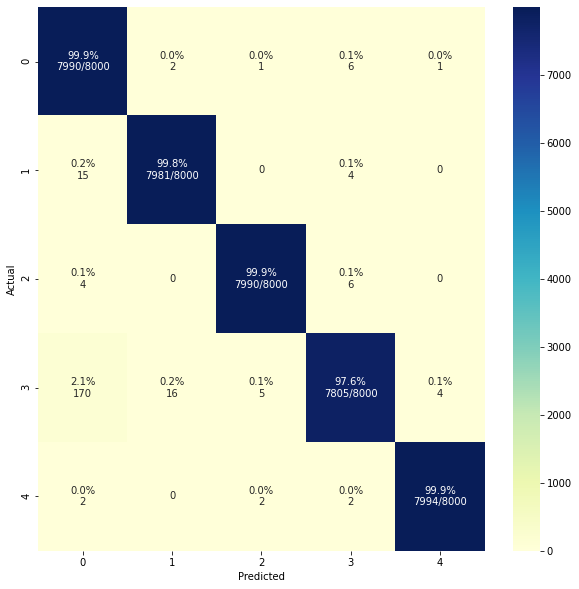

In [0]:
plot_cm(y_train, y_train_preds, 'train')
plot_cm(y_validate, y_validate_preds, 'validate')
plot_cm(y_test, y_test_preds, 'test')

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/1D_output/Utk_model_v2')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/1D_output/Utk_model_v2/assets


In [0]:
new_model = load_model('/content/drive/My Drive/Colab Notebooks/1D_output/Utk_model_v2')
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 187, 1)]     0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 183, 32)      192         input_1[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 183, 32)      5152        conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 183, 32)      0           conv1d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
y_test_preds = new_model.predict(x_test)

y_test_preds = [np.argmax(i) for i in y_test_preds ]

Confusion Matrix :
[[7990    2    1    6    1]
 [  15 7981    0    4    0]
 [   4    0 7990    6    0]
 [ 170   16    5 7805    4]
 [   2    0    2    2 7994]]
Accuracy Score : 0.994
Report : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      8000
           1       1.00      1.00      1.00      8000
           2       1.00      1.00      1.00      8000
           3       1.00      0.98      0.99      8000
           4       1.00      1.00      1.00      8000

    accuracy                           0.99     40000
   macro avg       0.99      0.99      0.99     40000
weighted avg       0.99      0.99      0.99     40000



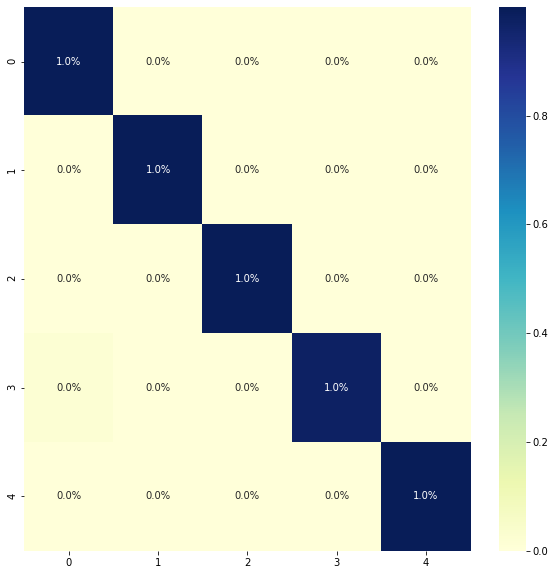

In [0]:
results = confusion_matrix(y_test, y_test_preds) 
  
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(y_test, y_test_preds))
print ('Report : ')
print (classification_report(y_test, y_test_preds))

cm = results.astype('float') / results.sum(axis=1)[:, np.newaxis]
nrows, ncols = cm.shape
annot = np.empty_like(cm).astype(str)

fig, ax = plt.subplots(figsize=(10, 10))
for i in range(nrows):
    for j in range(ncols):
        p = cm[i, j]
        if i == j:
            annot[i, j] = '%.01f%%' % (p)
        else:
            annot[i, j] = '%.01f%%' % (p)
sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)